# Example Serial Position Cells Visualization

This notebook contains plots of example cells from the spatial target analysis. 

In [44]:
%config Completer.use_jedi = False

In [71]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import sem, ttest_rel
from sklearn.preprocessing import MinMaxScaler

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.spatial.occupancy import (compute_bin_counts_assgn, compute_bin_edges, 
                                          compute_bin_assignment, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_occupancy, compute_bin_counts_pos
from spiketools.spatial.utils import compute_nbins, compute_pos_ranges, convert_2dindices
from spiketools.spatial.target import compute_target_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.utils import set_random_seed
from spiketools.utils.base import select_from_list
from spiketools.utils.data import compute_range
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import (epoch_data_by_range, epoch_spikes_by_segment, 
                                    epoch_spikes_by_range, epoch_spikes_by_event)

from spiketools.plts.data import plot_bar
from spiketools.plts.spatial import plot_heatmap, plot_positions, create_heat_title
from spiketools.plts.trials import plot_rasters
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes, save_figure, make_grid, get_grid_subplot

In [57]:
import sys
sys.path.append('../code')
from models import *
from utils import *
from plts import *

In [47]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [48]:
# Define the base data folder
data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/nwb'

In [49]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv001',
    'session' : 2
}

In [50]:
# Set which example unit to extract
uind = 0

In [51]:
# Define binning for chests (spatial target)
chest_bins = [3, 5]
bins = [5, 7]

n_bins = compute_nbins(chest_bins)

In [52]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

In [53]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {}
    #shuffle_kwargs = {'shuffle_min' : 20000}

In [54]:
# Set which analysis method to run
METHOD = 'ANOVA'  # 'SEGMENT' / 'ANOVA'

## Load data

In [10]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)

In [11]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

### Get trial data

In [12]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [13]:
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
ch_openings_all = np.array(chest_openings).reshape(-1,1)

### Get spike data

In [14]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 118
Number to keep:  85


In [74]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

In [20]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)

## One example serial position cell

#### Time spend in each serial position

In [119]:
segment_frs = compute_segment_frs(spikes, seg_times)

In [ ]:
seg_interval = np.zeros([seg_times.shape[0], 4])
for ind in range(seg_times.shape[0]):
    seg_interval[ind, :] = (np.diff(seg_times[ind])).tolist()

#### Spike count in each serial position

In [117]:
tseg_count = np.zeros([seg_times.shape[0], 4])
for ind, time in enumerate(seg_times):
    segment_spikes = epoch_spikes_by_segment(spikes, time)
    tseg_count[ind, :] = np.array([len(segment_spikes[0]), len(segment_spikes[1]), len(segment_spikes[2]), len(segment_spikes[3])])

seg_counts = np.sum(tseg_count, 0)

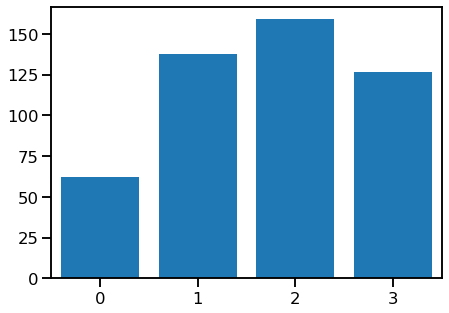

In [118]:
plot_bar(seg_counts, [0,1,2,3], figsize=(7,5))

#### Normalized raster plot 

In [26]:
def normalized_segment(t_spikes, nav_starts, chest_openings, n_trials):
    s0_spikes_all, s1_spikes_all, s2_spikes_all, s3_spikes_all = [],[],[],[]
    spikes_all = []

    min_max_scaler0 = MinMaxScaler(feature_range=(0, 1))
    min_max_scaler1 = MinMaxScaler(feature_range=(1, 2))
    min_max_scaler2 = MinMaxScaler(feature_range=(2, 3))
    min_max_scaler3 = MinMaxScaler(feature_range=(3, 4))

    s0_spikes = epoch_spikes_by_range(t_spikes, nav_starts, np.array(chest_openings)[:,0], reset=True)
    s0_spikes = [np.array(s0_spikes[ind]).reshape(-1, 1) for ind in range(n_trials)]

    s1_spikes = epoch_spikes_by_range(t_spikes, np.array(chest_openings)[:,0], 
                                      np.array(chest_openings)[:,1], reset=True)
    s1_spikes = [np.array(s1_spikes[ind]).reshape(-1, 1) for ind in range(n_trials)]

    s2_spikes = epoch_spikes_by_range(t_spikes, np.array(chest_openings)[:,1], 
                                      np.array(chest_openings)[:,2], reset=True)
    s2_spikes = [np.array(s2_spikes[ind]).reshape(-1, 1) for ind in range(n_trials)]

    s3_spikes = epoch_spikes_by_range(t_spikes, np.array(chest_openings)[:,2], 
                                      np.array(chest_openings)[:,3], reset=True)
    s3_spikes = [np.array(s3_spikes[ind]).reshape(-1, 1) for ind in range(n_trials)]

    for ind in range(n_trials): 
        if s0_spikes[ind].size !=0 : 
            s0_scaled = min_max_scaler0.fit_transform(s0_spikes[ind])
            s0_spikes_all.append(s0_scaled.flatten())
        else: 
            s0_scaled = np.array([])
            s0_spikes_all.append(s0_scaled)
        if s1_spikes[ind].size !=0 : 
            s1_scaled = min_max_scaler1.fit_transform(s1_spikes[ind])
            s1_spikes_all.append(s1_scaled.flatten())
        else: 
            s1_scaled = np.array([])
            s1_spikes_all.append(s1_scaled)
        if s2_spikes[ind].size !=0 : 
            s2_scaled = min_max_scaler2.fit_transform(s2_spikes[ind])
            s2_spikes_all.append(s2_scaled.flatten())
        else: 
            s2_scaled = np.array([])
            s2_spikes_all.append(s2_scaled)
        if s3_spikes[ind].size !=0 : 
            s3_scaled = min_max_scaler3.fit_transform(s3_spikes[ind])
            s3_spikes_all.append(s3_scaled.flatten())
        else: 
            s3_scaled = np.array([])
            s3_spikes_all.append(s3_scaled)

    spikes_trial = [np.hstack([s0_spikes_all[ind], s1_spikes_all[ind], s2_spikes_all[ind], s3_spikes_all[ind]])
                    for ind in range(n_trials)]
    return spikes_trial

In [28]:
trials_sp = epoch_spikes_by_range(spikes, nav_starts, np.array(chest_openings)[:,3], reset=False)
t_spikes = np.concatenate(trials_sp).ravel()

spikes_trial = normalized_segment(t_spikes, nav_starts, chest_openings, n_trials)

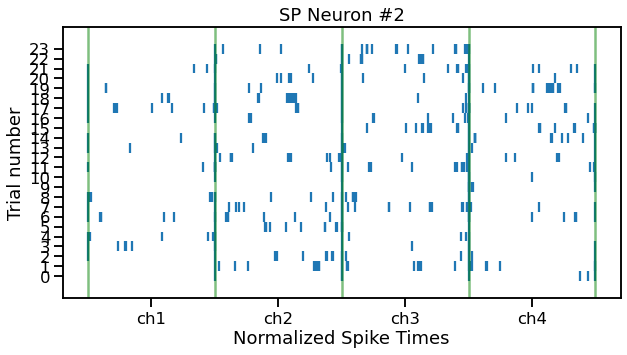

In [29]:
plot_segement_rasters(spikes_trial, 2, ['ch1','ch2','ch3','ch4'])

#### Fring rate in each serial position

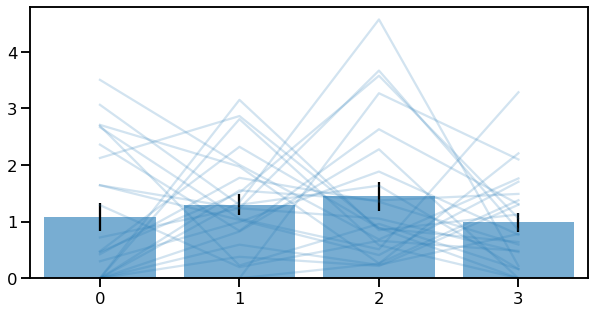

In [30]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
plot_bar(segment_frs.mean(0), [0, 1, 2, 3], yerr=sem(segment_frs, 0), alpha=0.6, color="C0", ax=ax)
for ind in range(len(segment_frs[:,0])): 
    ax.plot(['0','1','2','3'], segment_frs[ind], color='C0', alpha=0.2)

#### Surrogate Distribution

In [55]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [59]:
# Create dataframe
df = create_df_serial(segment_frs)

In [60]:
# Fit the ANOVA, and get f-value
f_val = fit_anova_serial(df)
f_val

0.8987582353527492

In [61]:
# Compute measures across shuffled time series for comparison
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    segment_frs = compute_segment_frs(shuffle, seg_times)
    df = create_df_serial(segment_frs)
    surrogates[ind] = fit_anova_serial(df)


In [62]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True)

p-value: 0.16
z-score: 0.57


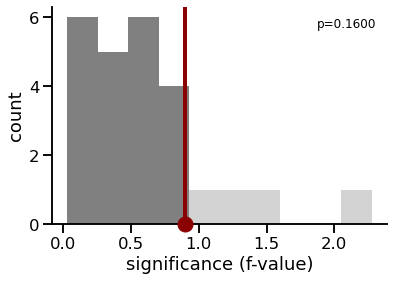

In [63]:
plot_surr_stats(surrogates, f_val, p_val, 10)

## Create report for significant cell

In [32]:
name = nwbfile.session_id + '_U' + str(uind).zfill(2)

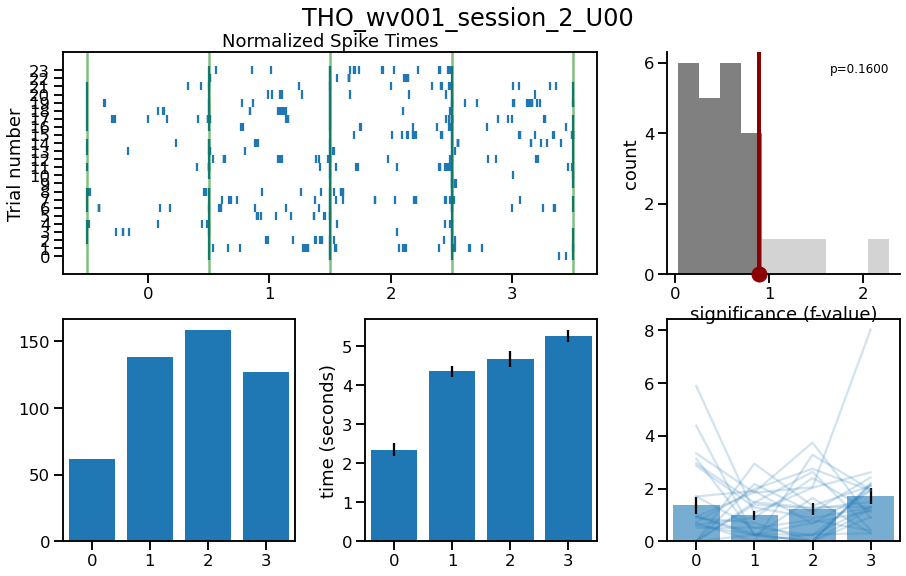

In [70]:
grid = make_grid(2, 3, figsize=(15, 9), wspace=0.3, title=name)
plot_rasters(spikes_trial, vline=[0, 1, 2, 3, 4], show_axis=True, figsize=(20, 10), 
             ax=get_grid_subplot(grid, 0, slice(0, 2),
                  title="Normalized Spike Times", ylabel="Trial number", 
                  xticks=[0.5, 1.5, 2.5, 3.5], yticks=range(0,len(spikes_trial)), xticklabels=[0,1,2,3]))

plot_bar(segment_frs.mean(0), [0, 1, 2, 3], yerr=sem(segment_frs, 0), alpha=0.6, color="C0", 
         ax=get_grid_subplot(grid, 1, 2))
for ind in range(len(segment_frs[:,0])): 
    get_grid_subplot(grid, 1, 2).plot(['0','1','2','3'], segment_frs[ind], color='C0', alpha=0.2)
plot_bar(seg_count, [0,1,2,3], ax=get_grid_subplot(grid, 1, 0))
plot_bar(seg_interval.mean(0), [0, 1, 2, 3], yerr=sem(seg_interval, 0), 
         ylabel='time (seconds)', ax=get_grid_subplot(grid, 1, 1))
plot_surr_stats(surrogates, f_val, p_val, 10, ax=get_grid_subplot(grid, 0, 2))

## All significant target cells

In [25]:
# Load & merge the results sheets of THF & THO
df_THF = pd.read_excel("/Users/Claire_han/Desktop/THF_all_results.xlsx")
df_THO = pd.read_excel("/Users/Claire_han/Desktop/THO_all_results.xlsx")
df = df_THF.append(df_THO)

In [26]:
# Create a dataframe for significant spatial target cells
df_target = df[df.is_target_cell]
df_target.head()

,Unnamed: 0,session,uid,wvID,keep,cluster,channel,location,n_spikes,firing_rate,...,sp_p_val,sp_z_score,area,fr_keep_th,is_chest_cell,is_full_cell,is_empty_cell,is_place_cell,is_target_cell,is_sp_cell
40,40,THF_wv001_session_0,56,57,1,3880,A2,LA,865,0.716115,...,0.122,1.106320,amygdala,False,False,False,False,False,True,False
55,55,THF_wv001_session_0,76,77,1,1843,A39,RAH,124,0.106832,...,0.544,-0.312780,ant hipp,True,False,False,False,False,True,False
58,58,THF_wv001_session_0,80,81,1,3031,A3,LA,569,0.457378,...,0.436,-0.142629,amygdala,True,False,False,False,False,True,False
95,95,THF_wv001_session_2,30,131,1,1208,A23,LPH,5056,3.017460,...,0.148,0.975862,post hipp,False,True,True,False,False,True,False
99,99,THF_wv001_session_2,40,141,1,2750,A29,RA,2359,1.406607,...,0.000,4.719226,amygdala,False,False,False,False,False,True,True
